In [2]:
import tensorflow as tf
import numpy as np 
import pandas as pd 
import librosa
import librosa.display
import os
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import python_speech_features
import IPython.display as ipd
import seaborn as sns
import cv2

def get_spectdata(wav, sr=16000, size=12726):
    spect = librosa.feature.melspectrogram(wav, sr=sr, hop_length=161)  
    log_spect = librosa.core.logamplitude(spect)
    data = log_spect
#     data = np.asarray(log_spect).reshape(size)
    return data, log_spect

def speed_tuning(wav): # 데이터 유실 최소화를 위해 tuning 범위는 (0.9, 1.1)까지만 사용
    speed_rate = np.random.uniform(0.9,1.1)
    wav_speed_tune = cv2.resize(wav, (1, int(len(wav) * speed_rate))).squeeze()
    if len(wav_speed_tune) < 16000: # speed rate < 1이라 음향신호가 압축되면 원래 length인 16000보다 짧아지므로 패딩
        pad_len = 16000 - len(wav_speed_tune)
        wav_speed_tune = np.r_[np.random.uniform(-0.001,0.001,int(pad_len/2)),
                               wav_speed_tune,
                               np.random.uniform(-0.001,0.001,int(np.ceil(pad_len/2)))]
    else: 
        cut_len = len(wav_speed_tune) - 16000
        wav_speed_tune = wav_speed_tune[int(cut_len/2):int(cut_len/2)+16000]
    return wav_speed_tune

def pitch_tuning(wav, sample_rate=16000):
    bins_per_octave = 24 

    pitch_pm = 4
    pitch_change = pitch_pm * 2*(np.random.uniform()-0.5)

    wav_pitch_changed = librosa.effects.pitch_shift(wav.astype('float64'), 
                                          sample_rate, n_steps=pitch_change, 
                                          bins_per_octave=bins_per_octave)
    return wav_pitch_changed

def bg_mixing(wav, bg): 
    start_ = np.random.randint(bg.shape[0]-16000) # bg를 랜덤으로 slicing하기 위한 장치
    bg_slice = bg[start_ : start_+16000] # 대상 sound의 길이(time)와 동일하게 bg slicing
    wav_with_bg = wav * np.random.uniform(0.8, 1.2) + bg_slice * np.random.uniform(0, 0.1)
    return wav_with_bg

def float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

def load_audio_file(file_path):
    input_length = 16000
    data = librosa.core.load(file_path, sr=16000)[0]
    if len(data) > input_length:
        data = data[:input_length]
    else:
        pad_len = 16000 - len(data)
        data = np.r_[np.random.uniform(-0.001,0.001,int(pad_len/2)),
                     data,
                     np.random.uniform(-0.001,0.001,int(np.ceil(pad_len/2)))]
    return data

ModuleNotFoundError: No module named 'cv2'

In [40]:
def load_audio_file(file_path):
    input_length = 16000
    data = librosa.core.load(file_path, sr=16000)[0]
    if len(data) > input_length:
        data = data[:input_length]
    else:
        pad_len = 16000 - len(data)
        data = np.r_[np.random.uniform(-0.001,0.001,int(pad_len/2)),
                     data,
                     np.random.uniform(-0.001,0.001,int(np.ceil(pad_len/2)))]
    return data

def get_spectdata(wav, sr=16000, size=12726):
    spect = librosa.feature.melspectrogram(wav, sr=sr, hop_length=161, n_fft=2048, n_mels=128)
    log_spect = librosa.core.logamplitude(spect)
    data = log_spect
#     data = np.asarray(log_spect).reshape(size)
    return data, log_spect

In [9]:
audio_path = '../data/train/audio/'
labels = os.listdir(audio_path)
file_path = audio_path + labels[0] + "/" # 라벨에 해당하는 파일들이 있는 경로
files = os.listdir(file_path) # 라벨에 해당하는 파일 리스트를 만듦.

In [16]:
labels[0]

'bed'

(128, 100)


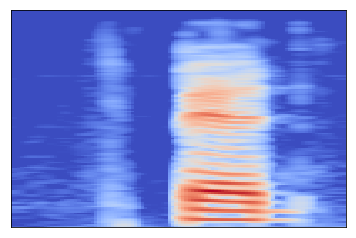

In [41]:
signal = load_audio_file(audio_path + labels[0] + '/' + files[0])
                
train_data = get_spectdata(signal)[0]
print(train_data.shape)
                
librosa.display.specshow(train_data)
plt.show()

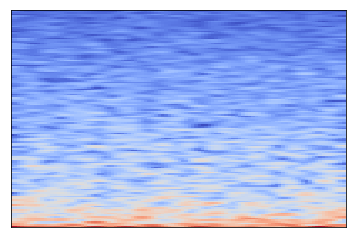

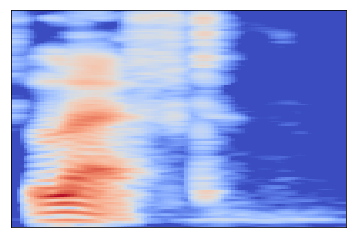

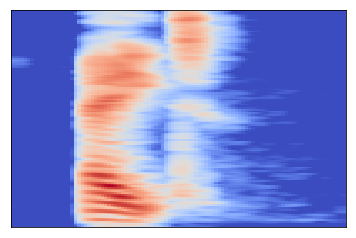

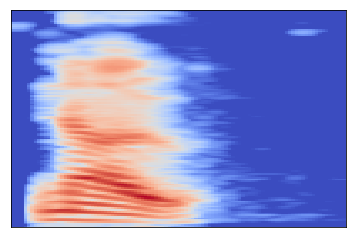

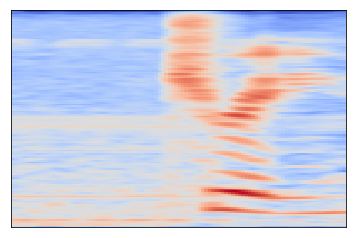

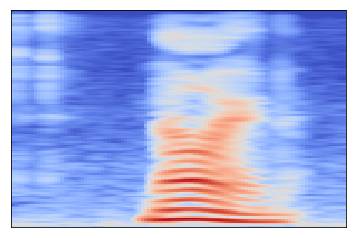

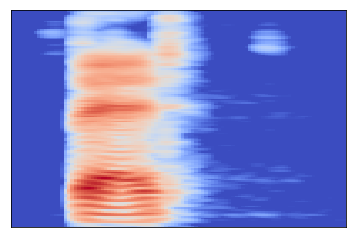

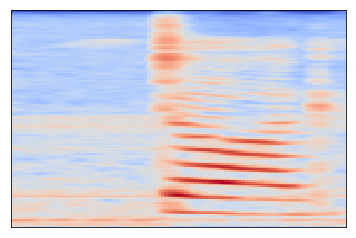

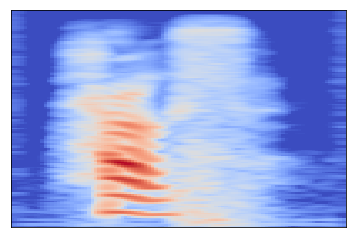

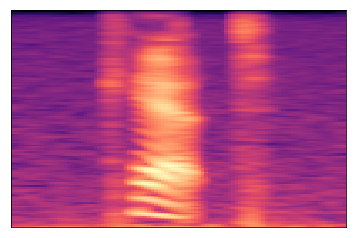

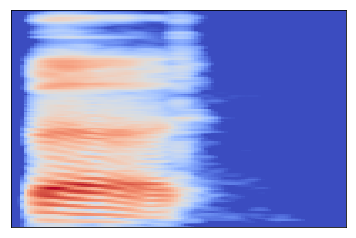

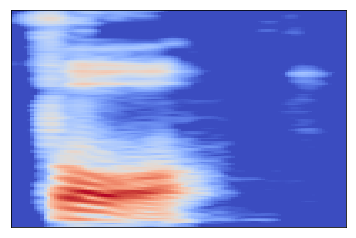

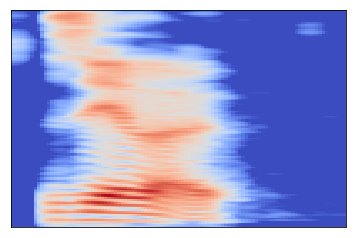

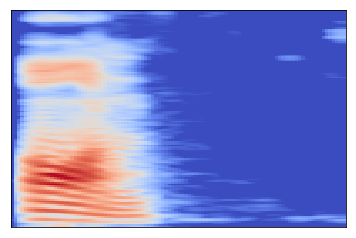

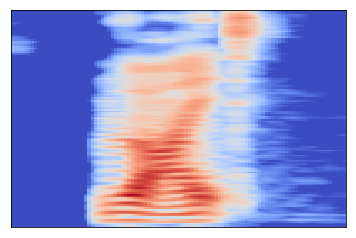

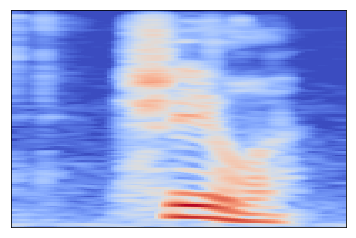

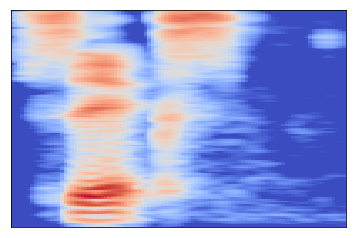

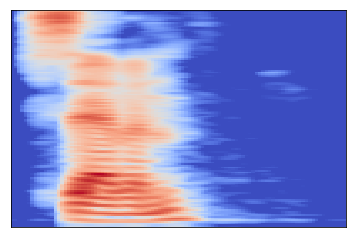

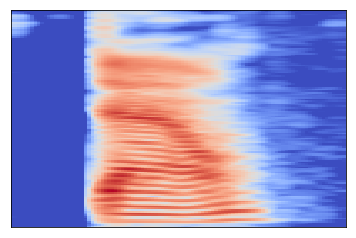

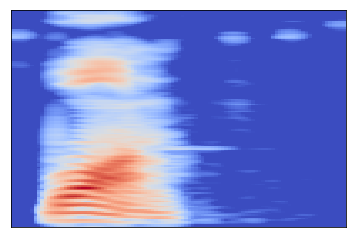

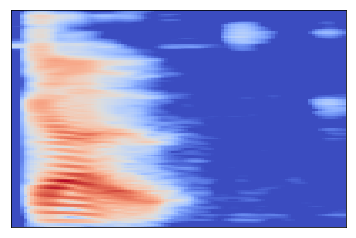

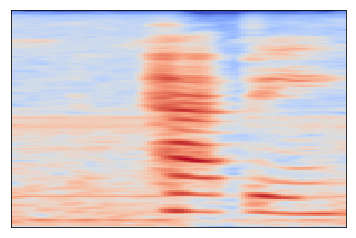

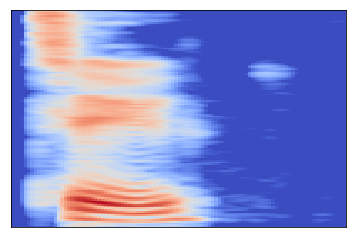

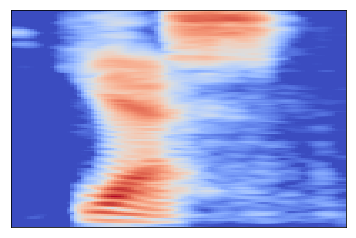

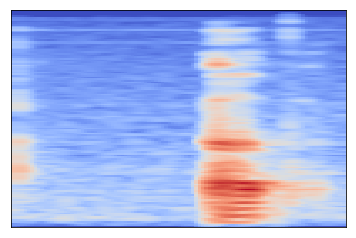

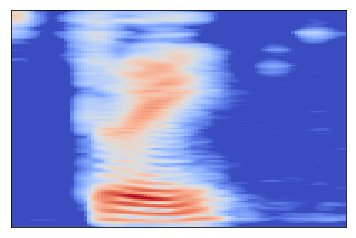

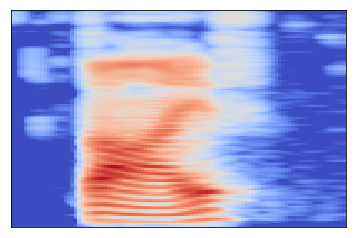

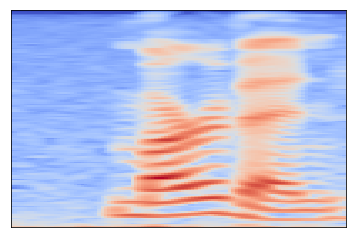

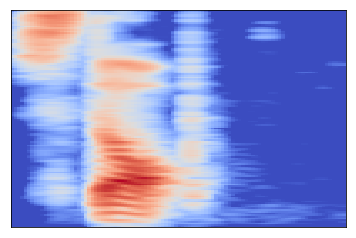

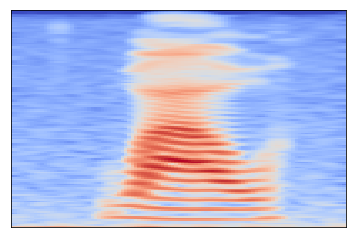

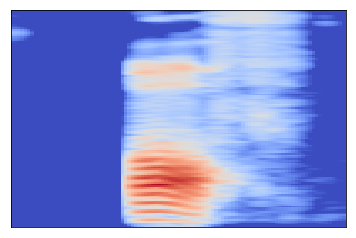

In [20]:
target_label = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go", "unknown", "silence"]
valid_labels = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go", "silence"]
lb = LabelBinarizer().fit(target_label)

bg_path = '../data/train/_background_noise_/'
bg_list = os.listdir(bg_path) 
bg_list.remove('README.md')

audio_path = '../data/train/audio/'
labels = os.listdir(audio_path) # train data 경로
# tfrecord_path = "/home/ubuntu/Project/data/tfrecords/train_new.tfrecord"

# writer = tf.python_io.TFRecordWriter(tfrecord_path)
    
for label in labels: # 경로의 하부 디렉토리명을 모두 읽고
    if label == '.DS_Store': continue
    else:
        orig_label = label # 오리지날 라벨로 명명 
        file_path = audio_path + label + "/" # 라벨에 해당하는 파일들이 있는 경로
        files = os.listdir(file_path) # 라벨에 해당하는 파일 리스트를 만듦.

        if label not in valid_labels: # train data 하부 디렉토리명이 valid_label에 속하지 않을 경우 해당 라벨은 unknown으로 명명
            label = "unknown"

        encoded_label = lb.transform([label])[0] # 라벨을 one hot encoding

        cnt = 0 # 라벨마다 파일 갯수 카운트 하기 위함
        
        for file in files[:1]:
            if file == '.DS_Store': continue
            else:
                filename = file_path + file #경로지정하고
                signal = load_audio_file(filename)
                
                train_data = get_spectdata(signal)[0]
                
                librosa.display.specshow(train_data)
                plt.show()

In [ ]:
target_label = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go", "unknown", "silence"]
valid_labels = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go", "silence"]
lb = LabelBinarizer().fit(target_label)


bg_path = '../data/train/_background_noise_/'
bg_list = os.listdir(bg_path) 
bg_list.remove('README.md')


audio_path = '../data/train/audio/'
labels = os.listdir(audio_path) # train data 경로
tfrecord_path = "/home/ubuntu/Project/data/tfrecords/train_new.tfrecord"

writer = tf.python_io.TFRecordWriter(tfrecord_path)
    
for label in labels: # 경로의 하부 디렉토리명을 모두 읽고
    if label == '.DS_Store': continue
    else:
        orig_label = label # 오리지날 라벨로 명명 
        file_path = audio_path + label + "/" # 라벨에 해당하는 파일들이 있는 경로
        files = os.listdir(file_path) # 라벨에 해당하는 파일 리스트를 만듦.

        if label not in valid_labels: # train data 하부 디렉토리명이 valid_label에 속하지 않을 경우 해당 라벨은 unknown으로 명명
            label = "unknown"

        encoded_label = lb.transform([label])[0] # 라벨을 one hot encoding

        cnt = 0 # 라벨마다 파일 갯수 카운트 하기 위함
        
        for file in files: #파일을 하나씩
            signal ={}
            if file == '.DS_Store': continue
            else:
                filename = file_path + file #경로지정하고
                signal[0] = load_audio_file(filename)
 
                signal[1] = speed_tuning(signal[0])

                signal[2] = pitch_tuning(signal[0])

                bg = librosa.load(bg_path + bg_list[np.random.randint(0, 5)] , sr=None)[0]
                signal[3] = bg_mixing(signal[0], bg)

                bg = librosa.load(bg_path + bg_list[np.random.randint(0, 5)] , sr=None)[0]
                signal[4] = bg_mixing((speed_tuning(signal[0])), bg)

                signal[5] = speed_tuning(pitch_tuning(signal[0]))

                bg = librosa.load(bg_path + bg_list[np.random.randint(0, 5)] , sr=None)[0]
                signal[6] = bg_mixing(pitch_tuning(signal[0]), bg)

                bg = librosa.load(bg_path + bg_list[np.random.randint(0, 5)] , sr=None)[0]
                signal[7] = bg_mixing(speed_tuning(pitch_tuning(signal[0])), bg)
                
                for i in signal.keys():
                    train_data = get_spectdata(signal[i])[0]
                    feature = {
                        "spectrum": float_feature(train_data),
                        "label": int64_feature(encoded_label)
                    }
                
                    features = tf.train.Features(feature=feature)
                    example = tf.train.Example(features=features)

                    writer.write(example.SerializeToString())
        
                    cnt += 1  
            
        print("Writing {} is complete. ({})".format(orig_label, cnt))
        
writer.close()